In [20]:
import pandas as pd

data = pd.read_csv(r'C:...\synthetic_data.csv', sep = '|', index_col=None)
data = data[['client', 'volume', 'product', 'action', 'ISIN',
       'isin_verb', 'Mean', 'Promedio']]

data.head()

,client,volume,product,action,ISIN,isin_verb,Mean,Promedio
0,t_391_L,610000,fx_CAD,BUY,EC0026456062,EC0026456062_BUY,400000,1.525000
1,t_391_L,10000,fx_THB,SELL,FP0827834135,FP0827834135_SELL,385000,0.025974
2,t_391_L,10000,fx_JPY,SELL,RE8007070338,RE8007070338_SELL,370000,0.027027
3,t_391_L,310000,fx_NZD,BUY,MB6443040517,MB6443040517_BUY,572500,0.541485
4,t_391_L,10000,fx_DKK,SELL,FQ2840854502,FQ2840854502_SELL,535000,0.018692


In [11]:
# This is EXACTLY the same as using sklearn LabelEncoding
data['client'] = data['client'].astype('category').cat.codes.values
data['isin_verb'] = data['isin_verb'].astype('category').cat.codes.values

X = data.loc[:, data.columns != 'Promedio']
y = data[['Promedio']]

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
y = scaler.fit_transform(y)

## 2.- Matrix Factorization

What is matrix factorization? Matrix factorization is simply a family of mathematical operations for matrices in linear algebra. To be specific, a matrix factorization is a factorization of a matrix into a product of matrices.

In the case of collaborative filtering, matrix factorization algorithms work by decomposing the user-item interaction matrix into the product of two lower dimensionality rectangular matrices. One matrix can be seen as the user matrix where rows represent users and columns are latent factors. The other matrix is the item matrix where rows are latent factors and columns represent items. How does matrix factorization solve our problems? Model learns to factorize rating matrix into user and movie representations, which allows model to predict better personalized movie ratings for users With matrix factorization, less-known movies can have rich latent representations as much as popular movies have, which improves recommender’s ability to recommend less-known movies.

Latent factors are the features in the lower dimension latent space projected from user-item interaction matrix. The idea behind matrix factorization is to use latent factors to represent user preferences or movie topics in a much lower dimension space. Matrix factorization is one of very effective dimension reduction techniques in machine learning.

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print('shape(X_train)=',X_train.shape)
print('shape(y_train)=',y_train.shape)
print('shape(X_test)=',X_test.shape)
print('shape(y_test)=',y_test.shape)

shape(X_train)= (13465, 7)
shape(y_train)= (13465, 1)
shape(X_test)= (3367, 7)
shape(y_test)= (3367, 1)


In [13]:
#Model packages
import keras
from keras.optimizers import Adam
from keras.models import Sequential, Input, Model
from keras.layers import LSTM, Dense, concatenate, Dropout, LSTM, GlobalMaxPool1D, MaxPooling1D, Flatten, Layer, Reshape, RepeatVector, Concatenate, Add, Activation
from keras.layers import Input, LSTM, Dense, RepeatVector, Concatenate, TimeDistributed, Reshape, Layer, Add, Conv2D, Conv1D
from keras.layers import Multiply, Activation, Lambda, Dot, Dropout, Flatten, Embedding, dot, merge
from keras import optimizers
from keras.layers.convolutional import Conv1D
from keras.regularizers import l2
from keras.layers import ELU
from keras.optimizers import Adam
from keras.models import model_from_json

In [14]:
dft.columns

Index(['client', 'volume', 'product', 'action', 'ISIN', 'isin_verb'], dtype='object')

In [15]:
n_latent = 18
n_users = len(X.client.unique())
n_items = len(X.isin_verb.unique())


input_user = Input(shape=[1], name='input_user')
input_item = Input(shape=[1], name='input_item')


# input_user_f = Input(shape=[1], name='input_user_features')
# input_item_f = Input(shape=[1], name='input_item_features')

#Embedding layer


MF_user_emb = Embedding(n_users,n_latent, #embeddings_constraint=keras.constraints.NonNeg(),
                       # embeddings_regularizer=keras.regularizers.l2(0),
                        name='embedding_user')(input_user)

MF_flatten_user = Flatten()(MF_user_emb)


MF_item_emb = Embedding(n_items,n_latent, #embeddings_constraint=keras.constraints.NonNeg(),
                      #  embeddings_regularizer=keras.regularizers.l2(0),
                        name='embedding_item')(input_item)

MF_flatten_item = Flatten()(MF_item_emb)


#MF part

mf_vec = dot([MF_flatten_user,MF_flatten_item],axes=1, name='prod',)    #keras.layers.multiply([MF_flatten_user,MF_flatten_item])

# mf_vec = keras.layers.multiply([MF_flatten_user,MF_flatten_item])    # dot([MF_flatten_user,MF_flatten_item],axes=1, name='prod')



model = Model([input_user,input_item], mf_vec)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_user (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_item (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_user (Embedding)      (None, 1, 18)        55638       input_user[0][0]                 
__________________________________________________________________________________________________
embedding_item (Embedding)      (None, 1, 18)        4428        input_item[0][0]                 
______________________________________________________________________________________________

In [16]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# checkpointer = ModelCheckpoint(filepath=os.path.join('model','model_%demb_191202_%s_ACTION.json' %(n_latent,to_save)),
#                                verbose=1,
#                                save_best_only='True',
#                                monitor='loss')

 
earlystopping = EarlyStopping(monitor='loss',
                              min_delta=0, patience=20,
                              verbose=0, mode='auto',
                              baseline=None,
                              restore_best_weights=False)

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.3333,
                  patience=3, min_lr=0.00001, verbose=1)

cbs = [earlystopping, reduce_lr] 

Epoch 1/100
526/526 [==============================] - 1s 1ms/step - loss: 0.1032
Epoch 2/100
526/526 [==============================] - 1s 2ms/step - loss: 0.0898
Epoch 3/100
526/526 [==============================] - 1s 1ms/step - loss: 0.0457
Epoch 4/100
526/526 [==============================] - 1s 1ms/step - loss: 0.0271
Epoch 5/100
526/526 [==============================] - 1s 2ms/step - loss: 0.0183
Epoch 6/100
526/526 [==============================] - 1s 1ms/step - loss: 0.0124
Epoch 7/100
526/526 [==============================] - 1s 1ms/step - loss: 0.0090
Epoch 8/100
526/526 [==============================] - 1s 1ms/step - loss: 0.0068
Epoch 9/100
526/526 [==============================] - 1s 1ms/step - loss: 0.0053
Epoch 10/100
526/526 [==============================] - 1s 2ms/step - loss: 0.0043
Epoch 11/100
526/526 [==============================] - 1s 1ms/step - loss: 0.0036
Epoch 12/100
526/526 [==============================] - 1s 2ms/step - loss: 0.0033
Epoch 13/100


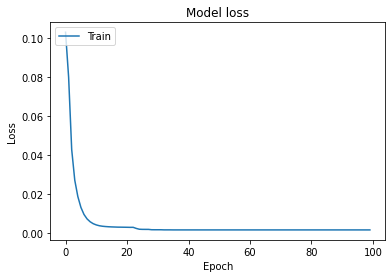

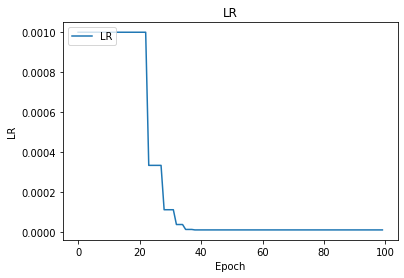

In [17]:
import matplotlib.pyplot as plt

lr = 0.001

n_steps = 10


adam = Adam(lr=lr,)
model.compile(optimizer=adam, loss='mse')
history = model.fit([X.client.values, X.isin_verb.values], y,
                    epochs=100,
                    batch_size=32,
                    shuffle = True,
                    callbacks=cbs) 


plt.plot(history.history['loss'])
#     plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

plt.plot(history.history['lr'])
#     plt.plot(history.history['val_loss'])
plt.title('LR')
plt.ylabel('LR')
plt.xlabel('Epoch')
plt.legend(['LR'], loc='upper left')
plt.show()

In [18]:
predict = model.predict([X.client.values,  X.isin_verb.values])
predict_train_unsca = scaler.inverse_transform(predict)
y_unsca = scaler.inverse_transform(y)

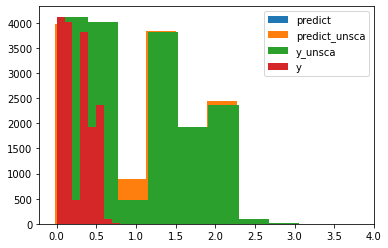

In [19]:
plt.hist(predict)
plt.hist(predict_train_unsca)
plt.hist(y_unsca)
plt.hist(y)
plt.legend(['predict', 'predict_unsca', 'y_unsca', 'y'])

In [20]:
dft.head()

,client,volume,product,action,ISIN,isin_verb
0,t_418_C,610000,fx_CHF,SELL,SI0515502572,SI0515502572_SELL
1,z_512_S,610000,fx_SEK,BUY,PD3458761640,PD3458761640_BUY
2,z_512_S,310000,fx_CNY,BUY,GY0845314388,GY0845314388_BUY
3,z_512_S,910000,fx_RON,SELL,PY1352306281,PY1352306281_SELL
4,z_512_S,10000,fx_HUF,SELL,YT1808716166,YT1808716166_SELL


In [21]:
products = pd.DataFrame({'Product': dft['isin_verb'], 'Product_cat': data['isin_verb'], 'Full_Name': dft['product']})
products = products.drop_duplicates()
print(products.shape)
products.head()

(246, 3)


,Product,Product_cat,Full_Name
0,SI0515502572_SELL,151,fx_CHF
1,PD3458761640_BUY,108,fx_SEK
2,GY0845314388_BUY,44,fx_CNY
3,PY1352306281_SELL,127,fx_RON
4,YT1808716166_SELL,233,fx_HUF


In [22]:
clients = pd.DataFrame({'Client': dft['client'], 'Client_cat': data['client']})
clients = clients.drop_duplicates()
print(clients.shape)

clients.head()

(3091, 2)


,Client,Client_cat
0,t_418_C,2284
1,z_512_S,3029
11,b_449_D,164
14,q_747_J,1942
22,e_746_R,547


In [23]:
for layer in model.layers:
#     print(layer.name)
    if layer.name == 'embedding_user':
#         print(layer.get_weights()[0].shape, layer.get_weights()[0])
        emb_user = pd.DataFrame(layer.get_weights()[0])
        print(emb_user.shape)
    if layer.name == 'embedding_item':
#         print(layer.get_weights()[0].shape, layer.get_weights()[0])
        emb_prod = pd.DataFrame(layer.get_weights()[0])
        print(emb_prod.shape)

emb_user['User'] = clients.Client.values
# emb_user['User_cat'] = clients.Client_cat.values


emb_prod['Product'] = products.Product.values
# emb_prod['Product_cat'] = products.Product_cat.values
# emb_prod['full_name_instrument'] = products.Full_Name.values

(3091, 18)
(246, 18)


In [24]:
import scipy

def get_distance(embedding_d, metric_d, type_d):
    dist_ = pd.DataFrame(scipy.spatial.distance.cdist(embedding_d.iloc[:,:-1],embedding_d.iloc[:,:-1], metric = metric_d))
    dist_.columns = embedding_d[type_d].values
    dist_.index = embedding_d[type_d].values
    return dist_

d_prod = get_distance(emb_prod, 'cosine', 'Product')
d_user = get_distance(emb_user, 'cosine', 'User')


def inverse_cum_sum(distance_, type_d):
    df_ = distance_.where(np.triu(np.ones(distance_.shape)).astype(np.bool))
    df_ = df_.stack().reset_index()
    df_.columns = [type_d + str(1) , type_d + str(2), 'Distance']
    df_ = df_[df_.Distance != 0]
    df_ = df_.sort_values(by = 'Distance')
    df_['CumSum'] = df_.Distance.cumsum()/df_.Distance.sum()
    df_['InverseCumSum'] = 1 - df_['CumSum']
    return df_

cum_sum_prods = inverse_cum_sum(d_prod, 'Product')

cum_sum_prods.sort_values(by = ['Product1', 'Distance'], ascending = False).head(8)

,Product1,Product2,Distance,CumSum,InverseCumSum
28986,ZT2060622447_SELL,EM5318136445_BUY,1.258528,0.830891,0.169109
28982,ZT2060622447_SELL,NR5238231251_SELL,1.220097,0.789738,0.210262
28971,ZT2060622447_SELL,ET2378478521_SELL,1.179109,0.741144,0.258856
28962,ZT2060622447_SELL,DZ4225453330_SELL,1.163180,0.721054,0.278946
28985,ZT2060622447_SELL,YX4135205087_BUY,1.145782,0.698048,0.301952
28961,ZT2060622447_SELL,LX8661262105_SELL,1.123915,0.667745,0.332255
28964,ZT2060622447_SELL,YO5255252178_SELL,1.120568,0.662783,0.337217
28977,ZT2060622447_SELL,HM6041202705_SELL,1.110701,0.649123,0.350877


In [25]:
cum_sum_users = inverse_cum_sum(d_user, 'User')
cum_sum_users.sort_values(by = ['User1', 'Distance'], ascending = False).head(20)

,User1,User2,Distance,CumSum,InverseCumSum
1271285,z_973_R,p_507_R,1.608379,0.997603,0.002397
1270525,z_973_R,e_740_Z,1.602337,0.997322,0.002678
1270748,z_973_R,p_685_L,1.559067,0.994697,0.005303
1270978,z_973_R,k_260_D,1.523661,0.991288,0.008712
1270138,z_973_R,r_936_Y,1.516787,0.990427,0.009573
1269707,z_973_R,k_530_Z,1.512683,0.989872,0.010128
1270258,z_973_R,a_387_G,1.507039,0.989096,0.010904
1271379,z_973_R,k_128_V,1.505809,0.988917,0.011083
1270396,z_973_R,w_753_K,1.483782,0.985485,0.014515
1269622,z_973_R,q_500_O,1.482927,0.985337,0.014663


In [26]:
dft.loc[dft['client'] == 'z_981_N']

,client,volume,product,action,ISIN,isin_verb


In [27]:
dft.loc[dft['client'] == 'c_724_K']

,client,volume,product,action,ISIN,isin_verb


In [28]:
r_user = cum_sum_users['User1'].sample(1).values[0]

firsts = cum_sum_users.loc[cum_sum_users['User1'] == r_user].sort_values(by = ['User1', 'Distance'], ascending = False).head(2)
lasts = cum_sum_users.loc[cum_sum_users['User1'] == r_user].sort_values(by = ['User1', 'Distance'], ascending = True).head(2)
most_similar = firsts.head(1)['User2'].values[0]
least_similar = lasts.head(1)['User2'].values[0]

most_similar, least_similar

('m_944_R', 'v_695_G')

In [29]:
dft.loc[dft['client'] == r_user]

,client,volume,product,action,ISIN,isin_verb
10945,k_545_K,610000,Andorra_15-20y,BUY,BA5345678662,BA5345678662_BUY
10946,k_545_K,10000,Anguilla_20y,BUY,QG6822726146,QG6822726146_BUY
10947,k_545_K,310000,Bosnia & Herzegovina_2-3y,BUY,ZT2060622447,ZT2060622447_BUY
10948,k_545_K,310000,Albania_5-10y,SELL,VT4285403780,VT4285403780_SELL


In [30]:
dft.loc[dft['client'] == least_similar]

,client,volume,product,action,ISIN,isin_verb
16533,v_695_G,310000,Antigua & Barbuda_5-10y,BUY,IN4308346134,IN4308346134_BUY
16534,v_695_G,310000,Azerbaijan_1-5y,BUY,HM6041202705,HM6041202705_BUY


In [31]:
dft.loc[dft['client'] == most_similar]

,client,volume,product,action,ISIN,isin_verb
10949,m_944_R,910000,United Arab Emirates_10-20y,BUY,YO5255252178,YO5255252178_BUY
10950,m_944_R,10000,Azerbaijan_1-5y,SELL,HM6041202705,HM6041202705_SELL
10951,m_944_R,910000,Burundi_20-25y,BUY,CO0011207172,CO0011207172_BUY
10952,m_944_R,910000,Samoa (American)_10-20y,SELL,VU5068243715,VU5068243715_SELL


In [32]:
df_als = pd.DataFrame({'client': data['client'], 'isin_v' : data['isin_verb'],  'Promedio': data['Promedio']})
df_als.head()

,client,isin_v,Promedio
0,2284,151,1.584416
1,3029,108,1.000000
2,3029,44,0.643918
3,3029,127,2.261954
4,3029,233,0.020619


In [33]:
!pip install pyspark

In [34]:
train, test = df_als.iloc[0:int(0.8 * df_als.shape[0])], df_als.iloc[int(0.8 * df_als.shape[0]):]

train.to_csv('train.csv', sep = '|', header=True, index=False)
train.to_csv('test.csv', sep = '|', header=True, index=False)

In [35]:
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("RECOMENDER") \
    .config('spark.driver.memory','2G') \
    .master('local[1]') \
    .getOrCreate()

df_train, df_test = spark.read.csv('train.csv', header=True,sep="|", inferSchema=True), spark.read.csv('test.csv', header=True, sep="|", inferSchema=True)
df_train.show(3)

+------+------+------------------+
|client|isin_v|          Promedio|
+------+------+------------------+
|  2284|   151|1.5844155844155845|
|  3029|   108|               1.0|
|  3029|    44|0.6439176782405677|
+------+------+------------------+
only showing top 3 rows



In [47]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row


# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=20, regParam=0.001, userCol="client", itemCol="isin_v", ratingCol="Promedio",
          coldStartStrategy="drop")
model = als.fit(df_train)

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(df_test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="Promedio",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

# Generate top 10 products recommendations for each user
userProducts = model.recommendForAllUsers(10)

Root-mean-square error = 0.15575720796745574


In [50]:
data[data['client'] == 1580]

,client,volume,product,action,ISIN,isin_verb,Mean,Promedio
7706,1580,910000,Antigua & Barbuda_5-10y,BUY,IN4308346134,60,486086,1.872097
7707,1580,910000,Angola_20y,SELL,ND8628628207,87,499393,1.822212
7708,1580,910000,Angola_20y,SELL,ND8628628207,87,499393,1.822212
7709,1580,10000,Antigua & Barbuda_5-10y,SELL,IN4308346134,61,480689,0.020803
7710,1580,910000,Austria_5y,BUY,VP7805754585,192,438089,2.077203
7711,1580,310000,Bosnia & Herzegovina_2-3y,SELL,ZT2060622447,245,460000,0.673913
7712,1580,610000,Burkina Faso_20-25y,BUY,EC6630847781,34,471016,1.295073
7713,1580,310000,Anguilla_20y,BUY,QG6822726146,132,479035,0.647134
7714,1580,910000,Anguilla_20y,BUY,QG6822726146,132,479035,1.899652
7715,1580,910000,Antarctica_10-15y,SELL,YX4135205087,237,476666,1.909094


In [48]:
query_user = 1580
prs = userProducts.filter(userProducts.client == query_user).collect()[0][1]
dict_prods = data[['isin_verb', 'product']].drop_duplicates().set_index('isin_verb').to_dict()


print(f" Products recommended for user {query_user}: ")

for index, pr in enumerate(prs):
  print(f" Product number {index} --->  {dict_prods['product'][pr[0]]}")

 Products recommended for user 1580: 
 Product number 0 --->  kr_WBB
 Product number 1 --->  fx_CHF
 Product number 2 --->  kr_XSI
 Product number 3 --->  fx_RUB
 Product number 4 --->  fx_TRY
 Product number 5 --->  kr_WBB
 Product number 6 --->  fx_GBP
 Product number 7 --->  kr_XTC
 Product number 8 --->  fx_ILS
 Product number 9 --->  kr_XVC


In [52]:
data[data['client'] == 222]

,client,volume,product,action,ISIN,isin_verb,Mean,Promedio
1871,222,610000,kr_STV,BUY,BT4735130183,14,505652,1.206363
1872,222,610000,kr_AMBER,SELL,VO1522754405,191,514545,1.185513
1873,222,10000,kr_GRC,SELL,CV5710306102,25,496666,0.020134
1874,222,10000,kr_NKT,BUY,JR0826457486,68,490000,0.020408


In [51]:
query_user = 222
prs = userProducts.filter(userProducts.client == query_user).collect()[0][1]
dict_prods = data[['isin_verb', 'product']].drop_duplicates().set_index('isin_verb').to_dict()


print(f" Products recommended for user {query_user}: ")

for index, pr in enumerate(prs):
  print(f" Product number {index} --->  {dict_prods['product'][pr[0]]}")

 Products recommended for user 222: 
 Product number 0 --->  fx_MXN
 Product number 1 --->  fx_IDR
 Product number 2 --->  fx_THB
 Product number 3 --->  fx_HKD
 Product number 4 --->  fx_MYR
 Product number 5 --->  fx_NZD
 Product number 6 --->  fx_PHP
 Product number 7 --->  Qualys, Inc. - Common Stock_10y
 Product number 8 --->  kr_STV
 Product number 9 --->  kr_AMBER


In [56]:
data[data['client'] == 100]

,client,volume,product,action,ISIN,isin_verb,Mean,Promedio
1421,100,310000,kr_8BIT,BUY,SX5173174584,154,512500,0.604878


In [55]:
query_user = 1
prs = userProducts.filter(userProducts.client == query_user).collect()[0][1]
dict_prods = data[['isin_verb', 'product']].drop_duplicates().set_index('isin_verb').to_dict()


print(f" Products recommended for user {query_user}: ")

for index, pr in enumerate(prs):
  print(f" Product number {index} --->  {dict_prods['product'][pr[0]]}")

 Products recommended for user 1: 
 Product number 0 --->  fx_BRL
 Product number 1 --->  Pacer Trendpilot US Bond ETF_5y
 Product number 2 --->  ProShares RAFI Long Short ETF_30y
 Product number 3 --->  Defiance Quantum ETF_2-3y
 Product number 4 --->  kr_XVC
 Product number 5 --->  kr_SLING
 Product number 6 --->  Invesco VRDO Tax-Free ETF_5y
 Product number 7 --->  kr_8BIT
 Product number 8 --->  ProShares RAFI Long Short ETF_30y
 Product number 9 --->  kr_XSI


In [31]:
data.head(7)

,client,volume,product,action,ISIN,isin_verb,Mean,Promedio
0,t_391_L,610000,fx_CAD,BUY,EC0026456062,EC0026456062_BUY,400000,1.525000
1,t_391_L,10000,fx_THB,SELL,FP0827834135,FP0827834135_SELL,385000,0.025974
2,t_391_L,10000,fx_JPY,SELL,RE8007070338,RE8007070338_SELL,370000,0.027027
3,t_391_L,310000,fx_NZD,BUY,MB6443040517,MB6443040517_BUY,572500,0.541485
4,t_391_L,10000,fx_DKK,SELL,FQ2840854502,FQ2840854502_SELL,535000,0.018692
5,t_391_L,610000,fx_AUD,SELL,ME8813151016,ME8813151016_SELL,430000,1.418605
6,t_391_L,610000,fx_DKK,SELL,FQ2840854502,FQ2840854502_SELL,535000,1.140187
